In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats
#import mlflow

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Feature Engineering

In [13]:
def perform_feature_engineering(file_path):

    data = pd.read_csv(file_path)

    # Define the target variable
    data['Sales_per_Customer'] = data['Sales per Customer']
    # Add lag Features for 'Sales per Customer' column
    for lag in range(1, 11):  # Sales per Customer data from 1 to 10 rows ago
        data[f'sales_per_customer_lag_{lag}'] = data['Sales per Customer'].shift(lag)

    # Add rolling statistics features for 'Sales per Customer' column
    data['sales_per_customer_rolling_mean_7'] = data['Sales per Customer'].rolling(window=7).mean()
    data['sales_per_customer_rolling_std_7'] = data['Sales per Customer'].rolling(window=7).std()
    data['sales_per_customer_rolling_mean_30'] = data['Sales per Customer'].rolling(window=30).mean()
    data['sales_per_customer_rolling_std_30'] = data['Sales per Customer'].rolling(window=30).std()

    # One-hot encode categorical columns
    data = pd.get_dummies(data, columns=['Category', 'Sub-Category'], drop_first=True)

    # Handle missing values created by lag/rolling features
    data.fillna(method='bfill', inplace=True)

    # Drop original Sales per Customer column to avoid redundancy
    data.drop(columns=['Sales per Customer'], inplace=True)

    return data

data = perform_feature_engineering('dataset/superstore-orders.csv')
data.to_csv('dataset/engineered_superstore_orders.csv', index=False)

### Data Preparation

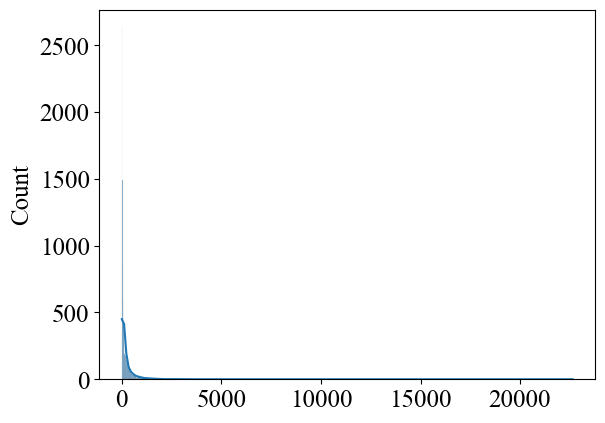

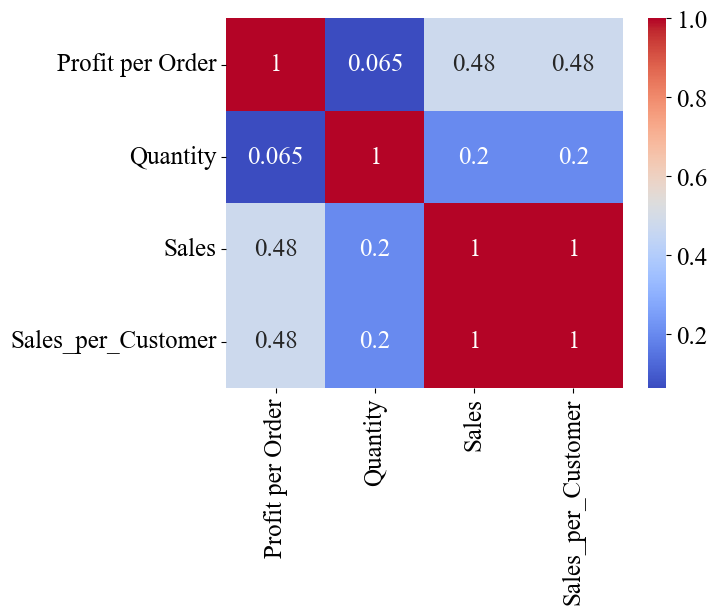

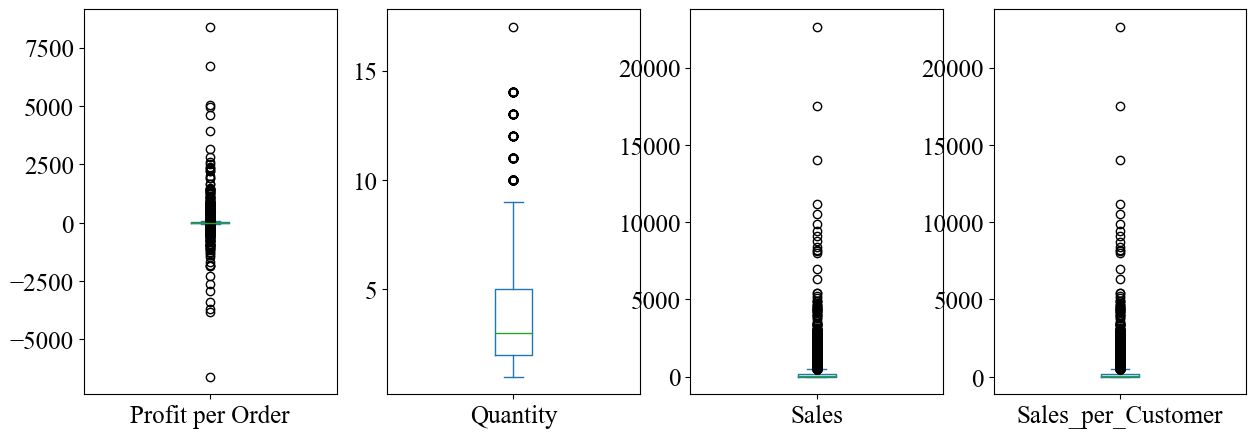

In [14]:
def prepare_data(file_path):
    
    data = pd.read_csv(file_path)

    X = data.drop(columns=['Sales_per_Customer'])
    y = data['Sales_per_Customer'] # target

    # Ensure all columns are numeric
    X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').values
    y = pd.Series(y).apply(pd.to_numeric, errors='coerce').values

    # Handle missing values if any
    X = np.nan_to_num(X, nan=0.0)
    y = np.nan_to_num(y, nan=0.0)

    # visualizing distributions of target variables and features
    sns.histplot(y, kde=True)
    plt.show()

    # correlation matrix
    columns = ['Profit per Order','Quantity','Sales','Sales_per_Customer']
    corr_matrix = data[columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.show()

    # box plot for outliers
    data[columns].plot(kind='box', subplots=True, layout=(1, len(columns)), sharex=False, sharey=False, figsize=(15, 5))
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # #convert data into tensor format
    # X_train = torch.tensor(X_train, dtype=torch.float32)
    # X_test = torch.tensor(X_test, dtype=torch.float32)
    # y_train = torch.tensor(y_train, dtype=torch.float32)
    # y_test = torch.tensor(y_test, dtype=torch.float32)

    # # channel dimension for conv1d
    # X_train = X_train.unsqueeze(1)
    # X_test = X_test.unsqueeze(1)

    return X_test, X_train, y_test, y_train

X_test, X_train, y_test, y_train = prepare_data(file_path='dataset/engineered_superstore_orders.csv')

## Models

### 1. Automated model selction using Auto - sklearn
### 2. Manually selecting a scikit learn model
### 3. Automated model selection using Auto - pytorch 

In [ ]:
import autosklearn.regression as ar

# create and fit automl regressor
automl_regressor = ar.AutoSklearnRegressor(time_left_for_this_task=1200, # run for an hour
                                           per_run_time_limit=200) # max time per model

automl_regressor.fit(X_train, y_train)

# print best model leaderboard
print(automl_regressor.leaderboard())

In [ ]:
# make predictions
y_pred = automl_regressor.predict(X_test)

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE = {mse}')
print(f'MAE = {mae}')
print(f'RMSE = {rmse}')
print(f'R2 Score = {r2}')

### manually select model

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

def train_and_evaluate_autosklearn(X_train, X_test, y_train, y_test, use_automl=True, model_name=None):
    if use_automl:
        automl_regressor = ar.AutoSklearnRegressor(time_left_for_this_task=1200,
                                                   per_run_time_limit=200)
        
        automl_regressor.fit(X_train, y_train)
        print(automl_regressor.leaderboard())
        y_pred = automl_regressor.predict(X_test)
    else:
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(),
            'Support Vector': SVR()
        }
        model = models[model_name]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test,y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'MSE = {mse}')
    print(f'MAE = {mae}')
    print(f'RMSE = {rmse}')
    print(f'R2 Score = {r2}')

    return mse, mae, rmse, r2

train_and_evaluate_autosklearn(X_train, X_test, y_train, y_test, use_automl=False, model_name='Random Forest')

### auto - pytorch

In [15]:
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError

/var/folders/3n/ckh6pd3914v4pkflqy1d548w0000gp/T/ipykernel_79826/2927579722.py:1: DeprecationWarning: Please use `QhullError` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import QhullError


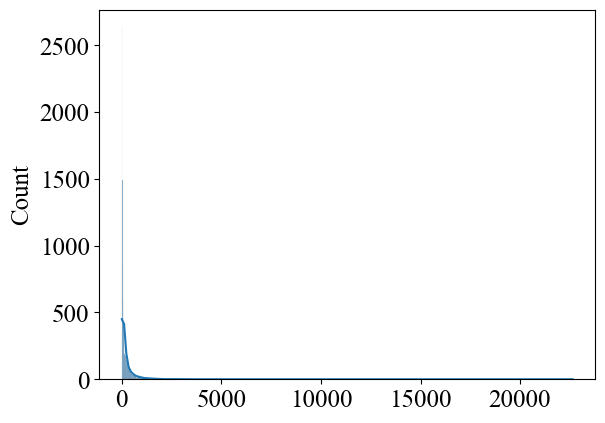

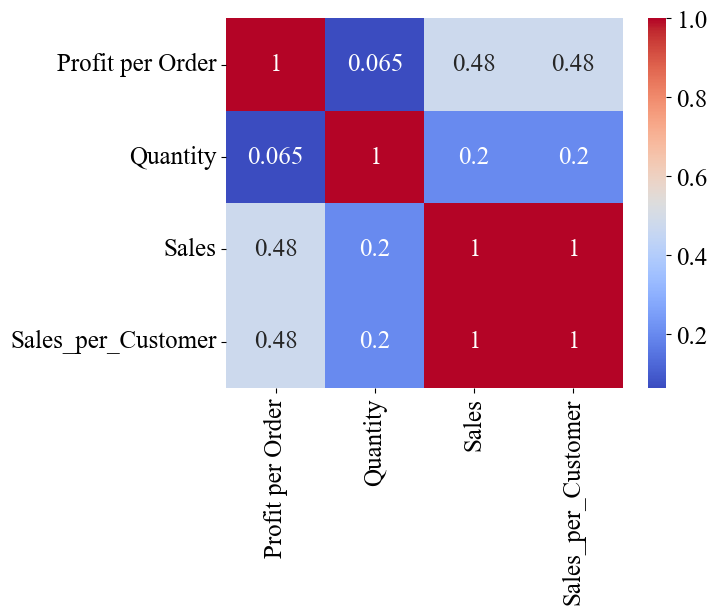

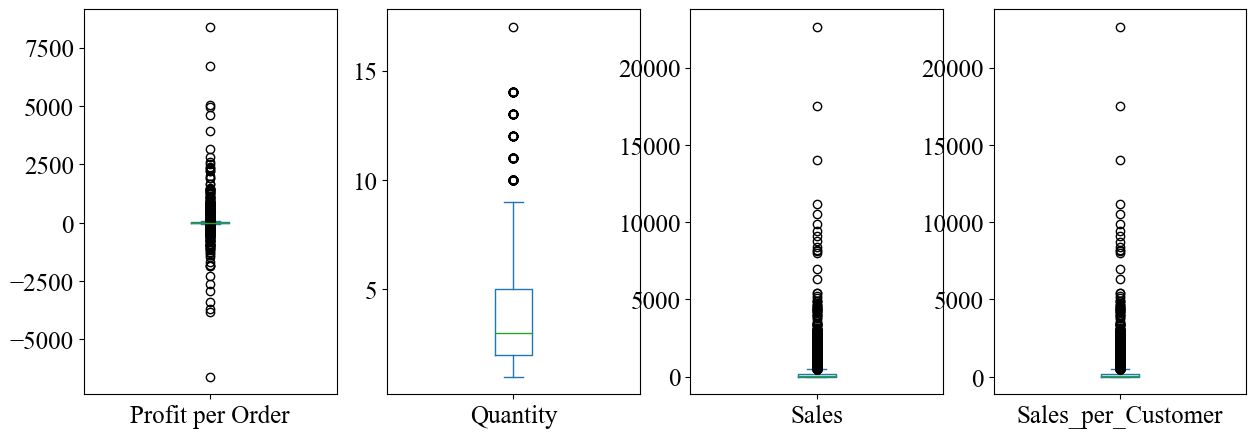

/Users/evc-m012/Documents/Evercot AI/Sales_Pred_AutoML/automl_env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/evc-m012/Documents/Evercot AI/Sales_Pred_AutoML/automl_env/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/evc-m012/Documents/Evercot AI/Sales_Pred_AutoML/automl_env/lib/python3.8/site-packages/autoPyTorch/pipeline/components/preprocessing/tabular_preprocessing/feature_preprocessing/Nystroem.py:130: UserW

ValueError: The default value has to be one of the choices. Got None which is not in ('fully_connected',).

In [22]:
from autoPyTorch.api.tabular_regression import TabularRegressionTask
# from autoPyTorch.pipeline.components.setup.network_backbone.utils import SearchSpaceUpdates

X_test, X_train, y_test, y_train = prepare_data(file_path='dataset/engineered_superstore_orders.csv')
api = TabularRegressionTask()
api.search(
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            optimize_metric='r2',
            total_walltime_limit=1200,
            func_eval_time_limit_secs=200
        )

y_pred = api.predict(X_test)
y_pred = np.array(y_pred).reshape(-1)

# def train_and_evaluate_autopytorch(X_train, X_test, y_train, y_test, use_automl=True, model_name=None):

#     if use_automl:
#         api = TabularRegressionTask()
#         api.search(
#             X_train=X_train,
#             y_train=y_train,
#             X_test=X_test,
#             y_test=y_test,
#             optimize_metric='r2',
#             total_walltime_limit=1200,
#             func_eval_time_limit_secs=200
#         )

#         y_pred = api.predict(X_test)
#         y_pred = np.array(y_pred).reshape(-1)
#     else:
#         models = {
#             'Linear Regression': LinearRegression(),
#             'Random Forest': RandomForestRegressor(),
#             'Support Vector': SVR()
#         }
#         model = models[model_name]
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)

mse = nn.MSELoss()(y_test, y_pred).item()
mae = nn.L1Loss()(y_test, y_pred).item()
rmse = torch.sqrt(nn.MSELoss()(y_test, y_pred)).item()
r2 = 1 - mse / torch.var(y_test).item()

print(f'MSE = {mse}')
print(f'MAE = {mae}')
print(f'RMSE = {rmse}')
print(f'R2 Score = {r2}')

#return mse, mae, rmse, r2

#train_and_evaluate_autopytorch(X_train, X_test, y_train, y_test, use_automl=True)
